In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import math
import sys
sys.path.append('../../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet_gated_without_skip import *
# from resnet_gated import *
# from resnet import *
from train import train, test
from dataset import *
from scheduler import CosineAnnealingWarmUpRestarts

In [2]:
#device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float

BATCH_SIZE = 64

In [3]:
image_paths = list(paths.list_images('../../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [4]:
len(set(labels))

101

In [5]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [6]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [7]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [8]:
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# model.eval()

In [10]:
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=5, T_mult=2, eta_max=0.1,  T_up=2, gamma=0.5)
# for i in range(30) :
#     EPOCH_LEARING_RATE = optimizer.param_groups[0]["lr"]
#     print(EPOCH_LEARING_RATE)
#     scheduler.step()

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch 1 of 100
train loss 0.0718 val loss 0.0744 train acc 2.01 val acc 7.57 lr 0.0001
Epoch 2 of 100
train loss 0.0643 val loss 0.0602 train acc 15.66 val acc 23.71 lr 0.0501
Epoch 3 of 100
train loss 0.0552 val loss 0.0548 train acc 25.06 val acc 27.11 lr 0.1000
Epoch 4 of 100
train loss 0.0490 val loss 0.0474 train acc 32.18 val acc 36.33 lr 0.0750
Epoch 5 of 100
train loss 0.0426 val loss 0.0434 train acc 38.88 val acc 41.16 lr 0.0251
Epoch 6 of 100
train loss 0.0397 val loss 0.0423 train acc 42.01 val acc 42.48 lr 0.0001
Epoch 7 of 100
train loss 0.0392 val loss 0.0410 train acc 42.70 val acc 43.80 lr 0.0250
Epoch 8 of 100
train loss 0.0377 val loss 0.0443 train acc 43.55 val acc 40.18 lr 0.0500
Epoch 9 of 100
train loss 0.0333 val loss 0.0365 train acc 49.00 val 

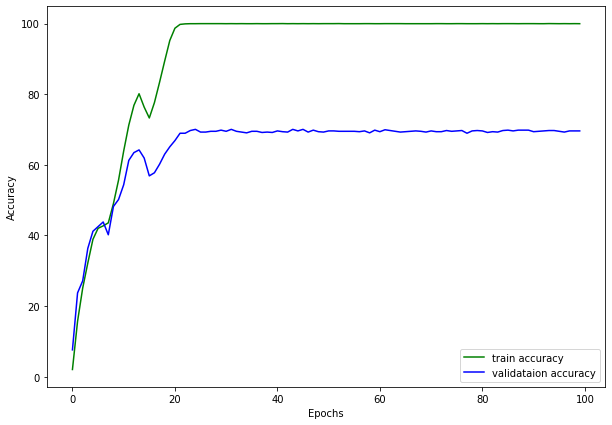

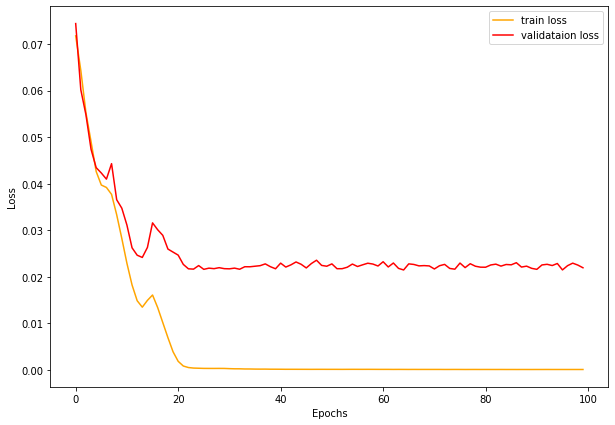

In [11]:
model = resnet18_gated_without_skip(pretrained=False).to(device)
train(model, trainloader, valloader, opt='sgd')
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))